In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from itertools import product
from sklearn import cross_validation, linear_model, metrics

Populating the interactive namespace from numpy and matplotlib


C:\Users\JB\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\JB\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [132]:
# выбираю для сортировки ячейку 1282 - с самым большим средним в мае 2016
# предварительно вытащил все данные по ячейке с 2014-01 по 2016-05 в файл cell_1282.csv
data = pd.read_csv('cell_1282.csv', sep=';', index_col=['date_hour'], header=0, 
                   parse_dates=['date_hour'], dayfirst=True)
data.drop([data.columns[0]], axis=1, inplace=True)
data.cell_1282 = data.cell_1282.astype(float)

In [4]:
# добавил руками одно нулевое значение в марте (вроде 07.03) в 02 часа, т.к. из-за его отсутствия в индексе ругалась 
# то ли АРИМА или преобразование бокса-кокса 
len(data)

21168

In [133]:
data.iloc[19250:19255]

,cell_1282
date_hour,
2016-03-13 02:00:00,279.0
2016-03-13 03:00:00,409.0
2016-03-13 04:00:00,304.0
2016-03-13 05:00:00,153.0
2016-03-13 06:00:00,117.0


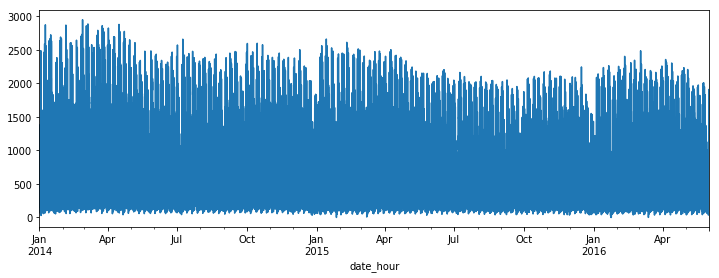

In [6]:
#нарисуем данные для визуального анализа
plt.figure(figsize=(12,4))
data.cell_1282.plot()
plt.show()

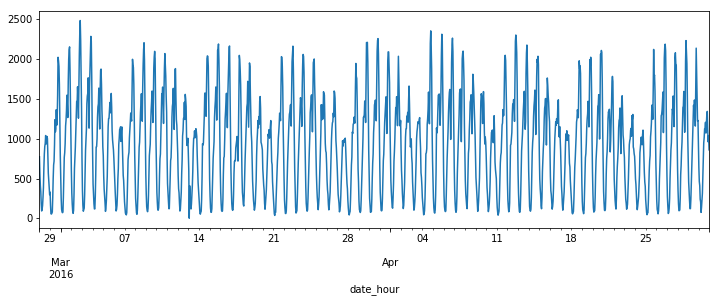

In [8]:
#нарисуем данные за 28.02.2016-30.04.2016, 18912:20424 для визуального анализа
# работать буду с этим периодом - 9 недель, на нем АРИМА у меня  строится 10-15 минут, иначе не хватит времени
# на сдачу задания, к тому же модель получается весьма неплохая и на этом периоде
plt.figure(figsize=(12,4))
data.cell_1282[18912:20424].plot()
plt.show()

четко видим дневную и недельную сезонность

Критерий Дики-Фуллера: p=0.000009


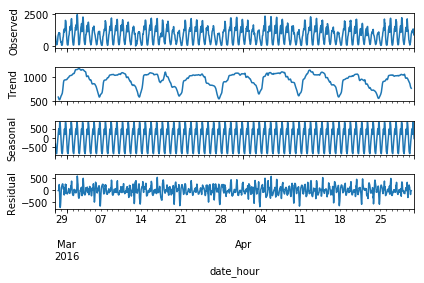

In [9]:
# построим как и на 5-м курсе STL-декомпозицию ряда и посчитаем критерий Дики-Фуллера
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.cell_1282[18912:20424])[1])
plt.figure(figsize=(20,8))
sm.tsa.seasonal_decompose(data.cell_1282[18912:20424]).plot()
plt.show()

тренда особого не вижу, есть недельная и дневная сезонность, странно но значение критерия Дики-Фуллера уже очень маленькое

Оптимальный параметр преобразования Бокса-Кокса: 0.573240
Критерий Дики-Фуллера: p=0.000000


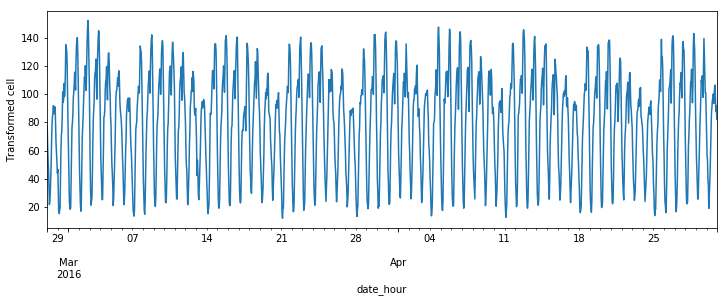

In [134]:
# сделаем преобразоваине бокса-кокса
# также это немного изменит данные, а то выскакивает ошибка с сингулярной матрицей
# при построении модели ARIMA
data['cell_1282_box'], lmbda = stats.boxcox(data['cell_1282'])
plt.figure(figsize(12,4))
data.cell_1282_box[18912:20424].plot()
plt.ylabel(u'Transformed cell')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.cell_1282_box)[1])

Критерий Дики-Фуллера: p=0.000003


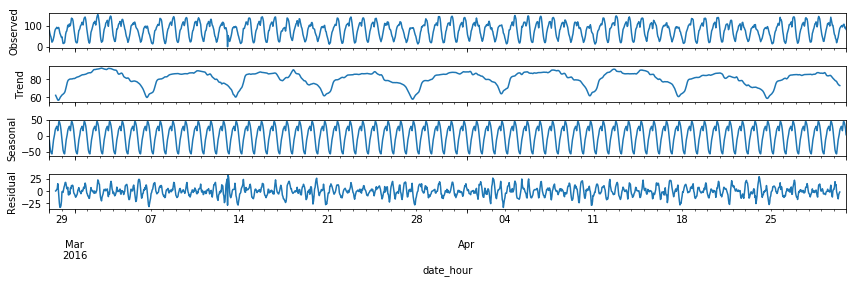

In [31]:
# еще раз построим STL-декомпозицию ряда и посчитаем критерий Дики-Фуллера
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.cell_1282_box[18912:20424])[1])
plt.figure(figsize=(20,8))
sm.tsa.seasonal_decompose(data.cell_1282_box[18912:20424]).plot()
plt.show()

пики сезонности стали более сглаженные, уменьшилась дисперсия что хорошо, ряд стал более стационарен

In [135]:
# дальше будем работать с этим набором данных
data_test = pd.DataFrame(data['cell_1282_box'][18912:20424])

In [6]:
data.iloc[18910:18912]

,cell_1282,cell_1282_box
date_hour,,
2016-02-27 22:00:00,939.0,86.532620
2016-02-27 23:00:00,807.0,79.189251


In [12]:
# Создадим регрессионные признаки для учёта сезонностей и трендов.
#Si=sin([1,…,T]∗2πi/168),Ci=cos([1,…,T]∗2πi/168),i=1,…,K.
# для теста регрессии возьму март и апрель 2016 , 1512 длина моделируемого ряда = 9 недель
itog_param = []
temp_param = []
K=7
KK = 10
arr_param = np.zeros((5544,21), dtype=float)

for j in range(K):
    temp_param = []
    for i in range(len(arr_param)):
#        S1 = sin((i+1)*2*np.pi*(j+1)/168.)    
#        C1 = cos((i+1)*2*np.pi*(j+1)/168.)    
#        temp_param.append([S1,C1,j+1])       
        arr_param[i,j*3] = sin((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*3+1] = cos((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*3+2] = j+1 #  j+1

In [13]:
arr_param.shape

(5544L, 21L)

In [16]:
len(arr_param)

5544

In [14]:
# Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, 
#сделайте регрессию целевого признака — количества поездок — на построенные признаки. 
#Посмотрите на остатки регрессии.
# Построю SGD регрессию по признакам и посмотрю на остатки 
# трейн сделаю за полгода, а тест на 9 недель март-апрель 2016
X_train = arr_param[:4032] # 5544 - 1512
y_train = data.cell_1282_box.iloc[14880:18912].values
X_test = arr_param[4032:]
y_test = data_test.cell_1282_box.values

# SGD регрессия
clf_SGD = linear_model.SGDRegressor()
clf_LOG = linear_model.LogisticRegression

clf_SGD.fit(X_train, y_train)
pred_SGD = clf_SGD.predict(X_test)
score_SGD = clf_SGD.score(X_test, y_test)

# Логистическая регрессия
#clf_LOG = linear_model.LogisticRegression()
#clf_LOG.fit(X_train, y_train)
#pred_LOG = clf_LOG.predict(X_test)
#score_LOG = clf_LOG.score(X_test, y_test)

C:\Users\JB\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [15]:
ostatki = y_test-pred_SGD
score_SGD

0.81746680023180995

In [16]:
pred_SGD

array([ 63.64746737,  55.48481953,  48.75747384, ...,  91.02766523,
        82.04053301,  72.70256258])

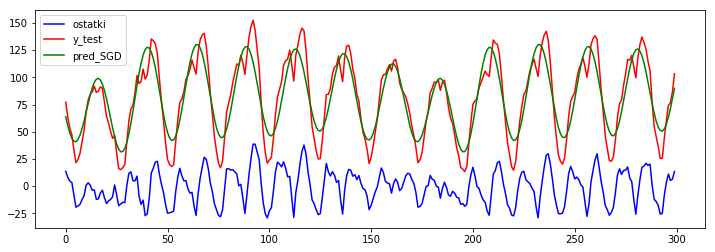

In [17]:
# посмотрим на остатки
plt.figure(figsize(12,4))
plot(ostatki[:300], 'b', label='ostatki')
plot(y_test[:300], 'r', label='y_test')
plot(pred_SGD[:300], 'g', label='pred_SGD')
plt.legend()

интересно получилось, SGD довольно точно предсказал значения и циклы, существенная разница только в амплитуде
остатки довольно большие, но недельная сезонность стала заметно меньше

Критерий Дики-Фуллера: p=0.000000


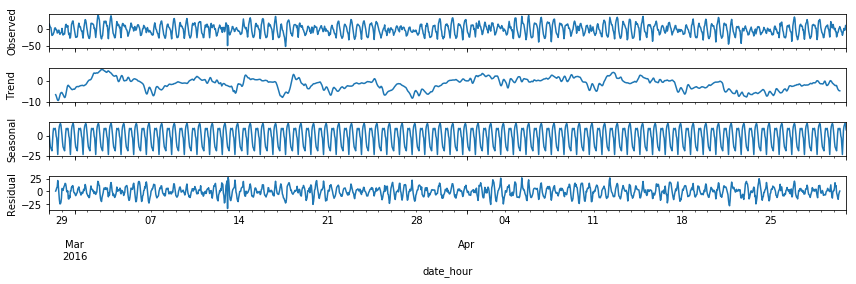

In [18]:
# попробуем продифференцировать остатки
# еще раз построим STL-декомпозицию ряда и посчитаем критерий Дики-Фуллера теперь по остаткам
data_ostatki = data_test
data_ostatki.cell_1282_box = ostatki
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_ostatki.cell_1282_box)[1])
plt.figure(figsize=(20,8))
sm.tsa.seasonal_decompose(data_ostatki.cell_1282_box).plot()
plt.show()

Критерий Дики-Фуллера: p=0.000020


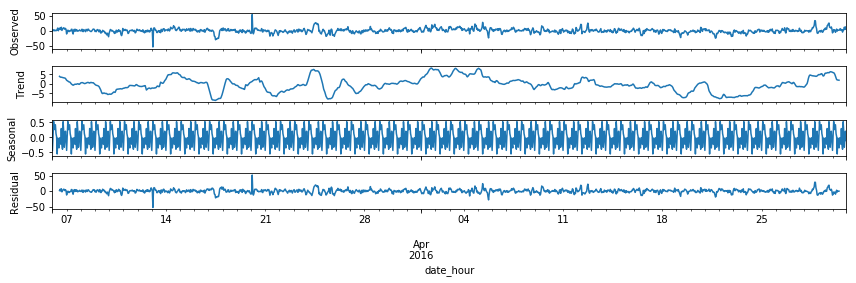

In [19]:
# попробую вычесть продифференцировать на 168 периодов, дальше поиграем с неделями
#data_ostatki.head(2)
data_ostatki['diff168'] = data_ostatki.cell_1282_box - data_ostatki.cell_1282_box.shift(168)
plt.figure(figsize(12,4))
sm.tsa.seasonal_decompose(data_ostatki['diff168'][168:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_ostatki['diff168'][168:])[1])

помоему ряд уже стационарен =) Дики фулер как всегда почти в нулях

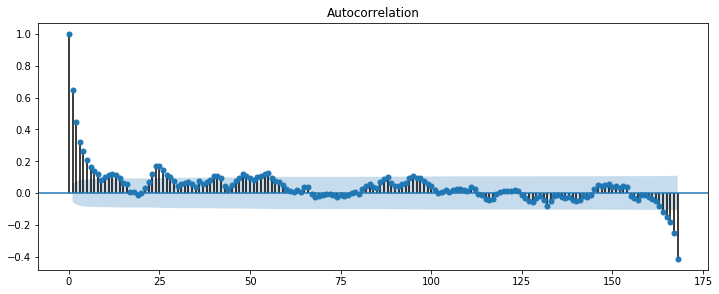

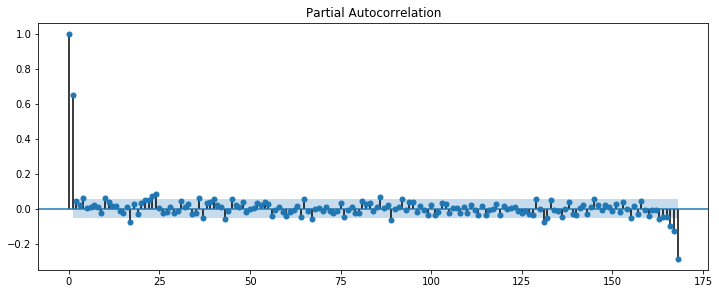

In [20]:
# Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) 
#с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), 
#подберите по ним начальные приближения для параметров p,q,P,Q
plt.figure(figsize(12,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_ostatki['diff168'][168:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_ostatki['diff168'][168:], lags=168, ax=ax)
pylab.show()

Возьмем начальные приближения: Q=0, q=1, P=1, p=1
если честно не очень понимаю зачем с ними столько мучаться, все равно делаем перебор, большими их 
делать тоже невыгодно

In [86]:
# Создадим регрессионные признаки для учёта сезонностей и трендов.
#Si=sin([1,…,T]∗2πi/168),Ci=cos([1,…,T]∗2πi/168),i=1,…,K.
# для теста регрессии возьму март и апрель 2016 , 1512 длина моделируемого ряда = 9 недель
itog_param = []
temp_param = []
K=9
KK = 10
arr_param = np.zeros((1512,18), dtype=float)

for j in range(K):
    temp_param = []
    for i in range(len(arr_param)):    
        arr_param[i,j*2] = sin((i+1)*2*np.pi*(j+1)/168.)
        arr_param[i,j*2+1] = cos((i+1)*2*np.pi*(j+1)/168.)
#        arr_param[i,j*3+2] = KK #  j+1

In [63]:
# возьмем начальные параметры модели как и в задании на 5-м месяце
ps = range(3, 4)
d=1
qs = range(1, 2)
Ps = range(1, 2)
D=1
Qs = range(1, 2)

In [64]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
parameters_list

[(3, 1, 1, 1)]

In [93]:
# подготовим регрессионные признаки для ARIMA
exog_ = sm.add_constant(arr_param)

In [95]:
exog_[0]

array([ 1.        ,  0.03739119,  0.9993007 ,  0.07473009,  0.9972038 ,
        0.11196448,  0.99371221,  0.14904227,  0.98883083,  0.18591161,
        0.98256647,  0.22252093,  0.97492791,  0.25881905,  0.96592583,
        0.29475517,  0.95557281,  0.33027906,  0.94388333])

In [43]:
#exog_[1509:1512]

In [136]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_test.cell_1282_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=False) #, exog=exog_
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')


Wall time: 22.6 s


In [137]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
0  (3, 1, 1, 1)  9252.008351


In [100]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      cell_1282_box   No. Observations:                 1512
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -4737.752
Date:                            Mon, 09 Jul 2018   AIC                           9489.503
Time:                                    13:08:37   BIC                           9526.751
Sample:                                02-28-2016   HQIC                          9503.374
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0510      0.025     42.005      0.000       1.002       1.100
ar.L2         -0.1160      0.026   

### Анализ остатков построенной модели

Критерий Стьюдента: p=0.929507
Критерий Дики-Фуллера: p=0.000000


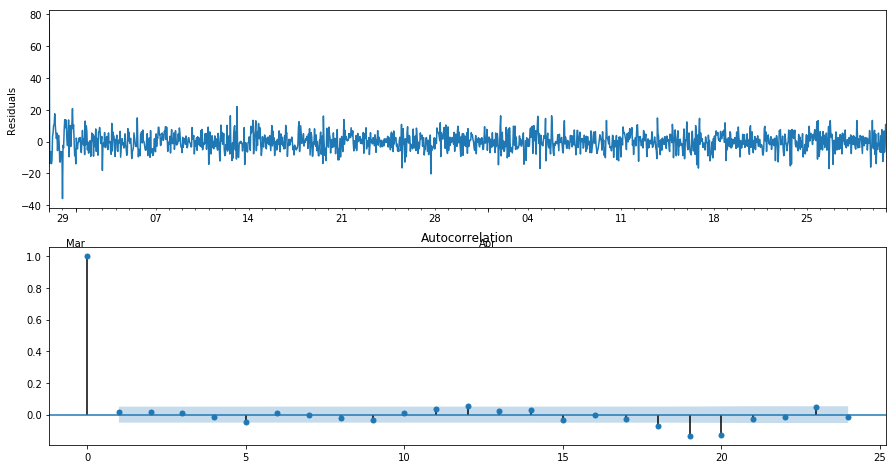

In [138]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[:].values.squeeze(), lags=24, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

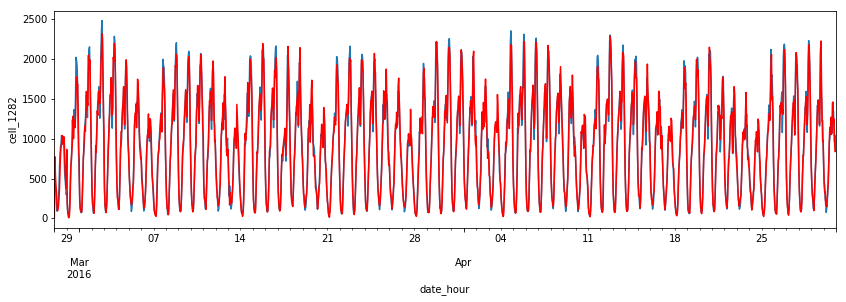

In [139]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
#data['model'] = best_model.fittedvalues
plt.figure(figsize(14,4))
data.cell_1282[18912:20424].plot()
data.model[18912:20424].plot(color='r')
plt.ylabel('cell_1282')
pylab.show()

построил довольно хорошую модель с 1-м значением косинусов и синусов, при 7-10 выдает сингулярную матрицу =(
при регрессии строилась хорошая модель при 7 и более синусов/косинусов 
параметры модели долго гонял, 3-1-1-1 получилась лучшая, последние разы брал только ее для экономии времени
хуже всего модель отработала 13 марта, в данных 0 а у модели есть значение
в выходные и понедельник остатки меньше 

In [143]:
data.iloc[19250:19252] 

,cell_1282,cell_1282_box,model
date_hour,,,
2016-03-13 02:00:00,279.0,42.268657,411.271670
2016-03-13 03:00:00,409.0,53.059042,166.867101


In [127]:
data2 = data[data.index.strftime("%H:%M:%S") == '02:00:00']

In [131]:
data2.cell_1282.mean()

279.3548752834467

In [52]:
data_noNane = data.dropna()

In [53]:
len(data_noNane)

1511

In [140]:
print('Коэффициент детерминации модели: {:.2f}'.format(
    metrics.r2_score(data.cell_1282[18912:20424], data.model[18912:20424])))

Коэффициент детерминации модели: 0.97
